# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Check GPU
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(1))

2
NVIDIA GeForce RTX 3090


# Part D

## Implement Custom Resnet  - Skip Connection 

In [3]:
class CustomResNet_NSC(nn.Module):
    def __init__(self):
        super(CustomResNet_NSC, self).__init__()

        # Initial layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        #  block 1 
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # block 2
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # block 3 
        self.conv6 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        # Final layers
        self.avg_pool = nn.AvgPool2d(kernel_size=3)
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = self.pool1(x)

        # block 1
        x = F.elu(self.conv3(x))
        x = F.elu(self.conv4(x))

        # block 2
        x = F.elu(self.conv5(x))
        x = self.pool2(x)

        # block 3
        x = F.elu(self.conv6(x))
        x = self.pool3(x)
        x = F.elu(self.conv7(x))

        # Final layers
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = F.elu(self.fc1(x))
        x = self.fc2(x)

        return x

## Load Dataset

In [4]:
# Data augmentation and normalization
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# # Data augmentation and normalization for training
# transform_train = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(15),
#     transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Splitting train dataset into train and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## Optimizer and Train Setup

In [6]:
# Model, optimizer, and scheduler
model = CustomResNet_NSC()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=40, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [7]:
# Determine if CUDA is available and set the device accordingly
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model.to(device)

CustomResNet_NSC(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (avg_pool): AvgPool2d(kernel_size=3, stride=3, padding=0)
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True

In [8]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100 * correct / total
    return train_loss, train_accuracy

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            _, predicted = output.max(1)
            correct += predicted.eq(target).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

# Training loop with tracking of training and validation accuracies
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
best_val_accuracy = 0
best_model_weights = None


In [9]:
for epoch in range(1, 61):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer , criterion)
    val_loss, val_accuracy = test(model, device, val_loader , criterion)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_weights = model.state_dict()

    print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    scheduler.step()

Epoch: 1, Train Loss: 2.2991, Train Accuracy: 12.70%, Val Loss: 2.2652, Val Accuracy: 17.10%
Epoch: 2, Train Loss: 2.0428, Train Accuracy: 23.51%, Val Loss: 1.9574, Val Accuracy: 26.76%
Epoch: 3, Train Loss: 1.8331, Train Accuracy: 31.88%, Val Loss: 1.6983, Val Accuracy: 38.18%
Epoch: 4, Train Loss: 1.6142, Train Accuracy: 39.92%, Val Loss: 1.5506, Val Accuracy: 42.72%
Epoch: 5, Train Loss: 1.4822, Train Accuracy: 44.99%, Val Loss: 1.4270, Val Accuracy: 48.06%
Epoch: 6, Train Loss: 1.3771, Train Accuracy: 49.58%, Val Loss: 1.3293, Val Accuracy: 51.84%
Epoch: 7, Train Loss: 1.2599, Train Accuracy: 54.38%, Val Loss: 1.2392, Val Accuracy: 56.52%
Epoch: 8, Train Loss: 1.1534, Train Accuracy: 58.32%, Val Loss: 1.1189, Val Accuracy: 60.74%
Epoch: 9, Train Loss: 1.0532, Train Accuracy: 62.59%, Val Loss: 1.0410, Val Accuracy: 64.08%
Epoch: 10, Train Loss: 0.9841, Train Accuracy: 65.07%, Val Loss: 0.9607, Val Accuracy: 66.38%
Epoch: 11, Train Loss: 0.9112, Train Accuracy: 67.69%, Val Loss: 0.95

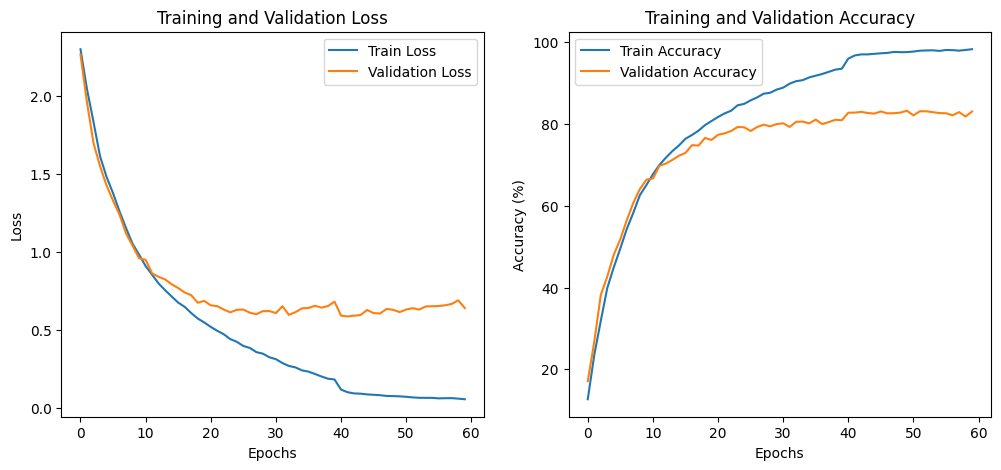

Best Validation Accuracy: 83.24%
Test Accuracy of the final model: 83.94%


In [10]:
# Load best model weights and evaluate on test set
model.load_state_dict(best_model_weights)
test_loss, test_accuracy = test(model, device, test_loader , criterion)

# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# Print best validation accuracy and test accuracy
print(f'Best Validation Accuracy: {best_val_accuracy:.2f}%')
print(f'Test Accuracy of the final model: {test_accuracy:.2f}%')

# Save best model weights
torch.save(best_model_weights, 'best_custom_resnet_weights_NSC.pth')

# Layer Wise analyse

In [ ]:
# download Pretrained Weight of model
import gdown
id = "1-SqLxoXC70RJXNOLvRlEu9D65qRNE0D"
gdown.download(id=id, quiet=False)

In [ ]:
!git clone https://github.com/Arhosseini77/data_complexity_measures

In [3]:
from data_complexity_measures.models.ARH_SeparationIndex import ARH_SeparationIndex

In [4]:
class CustomResNet_NSC(nn.Module):
    def __init__(self):
        super(CustomResNet_NSC, self).__init__()

        # Initial layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        #  block 1 
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # block 2
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # block 3 
        self.conv6 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        # Final layers
        self.avg_pool = nn.AvgPool2d(kernel_size=3)
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = self.pool1(x)

        # block 1
        x = F.elu(self.conv3(x))
        x = F.elu(self.conv4(x))

        # block 2
        x = F.elu(self.conv5(x))
        x = self.pool2(x)

        # block 3
        x = F.elu(self.conv6(x))
        x = self.pool3(x)
        x = F.elu(self.conv7(x))

        # Final layers
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = F.elu(self.fc1(x))
        x = self.fc2(x)

        return x

In [5]:
# Data augmentation and normalization
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Splitting train dataset into train and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


# Further split train_dataset into train_loader_dataset and 20% balanced subset
train_loader_dataset, _ = train_test_split(train_dataset.dataset, train_size=int(0.2 * len(train_dataset)),
                                           test_size=None, shuffle=True, stratify=train_dataset.dataset.targets)

# Data loaders
train_loader = DataLoader(train_loader_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# Instantiate and load the model
model = CustomResNet_NSC()  # Make sure CustomResNet is defined as earlier
model.load_state_dict(torch.load('best_custom_resnet_weights_NSC.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

CustomResNet_NSC(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (avg_pool): AvgPool2d(kernel_size=3, stride=3, padding=0)
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True

In [8]:
# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'match_conv1', 'match_conv2', 'match_conv3', 'fc1', 'fc2'}

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

## SI and CenterSI layer for Train Loader

In [17]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    else:
        print(f"No features captured for layer {layer_name}")

# Concatenate the labels
labels = torch.cat(labels_list)

100%|██████████| 36/36 [00:00<00:00, 103.95it/s]


### Calc SI

In [18]:
si_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=2000)
    si_layer_train.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 394.11it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6971.91it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 5471.31it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7206.71it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7937.74it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7294.44it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7568.21it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7667.83it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7426.18it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7309.70it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6301.54it/s]


In [19]:
si_layer_train

[('conv1', 0.22611111402511597),
 ('conv2', 0.20688888430595398),
 ('pool1', 0.31344443559646606),
 ('conv3', 0.37122222781181335),
 ('conv4', 0.41822221875190735),
 ('conv5', 0.4583333432674408),
 ('pool2', 0.48811110854148865),
 ('conv6', 0.5727778077125549),
 ('pool3', 0.5433333516120911),
 ('conv7', 0.6558889150619507),
 ('avg_pool', 0.7607777714729309)]

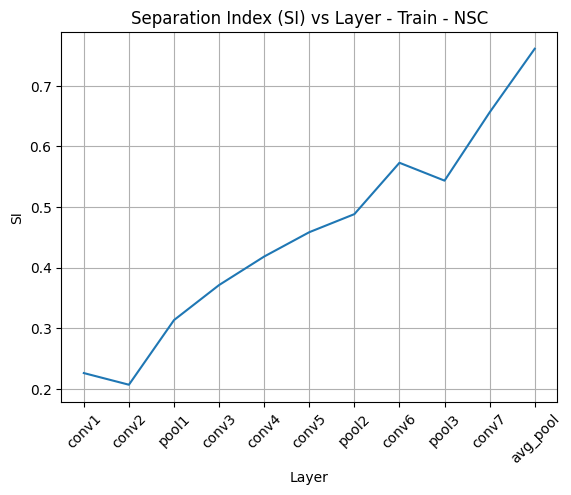

In [20]:
# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in si_layer_train], [si for _, si in si_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (SI) vs Layer - Train - NSC')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Calc Center Si

In [21]:
csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 862.53it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4006.79it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3027.07it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3265.07it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3371.09it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4071.35it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3852.23it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3165.99it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4069.77it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4168.46it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2890.63it/s]


[('conv1', 0.3485555648803711), ('conv2', 0.35600000619888306), ('pool1', 0.44733333587646484), ('conv3', 0.47288888692855835), ('conv4', 0.5081111192703247), ('conv5', 0.5166666507720947), ('pool2', 0.5691111087799072), ('conv6', 0.5683333277702332), ('pool3', 0.6520000100135803), ('conv7', 0.6694444417953491), ('avg_pool', 0.7893333435058594)]


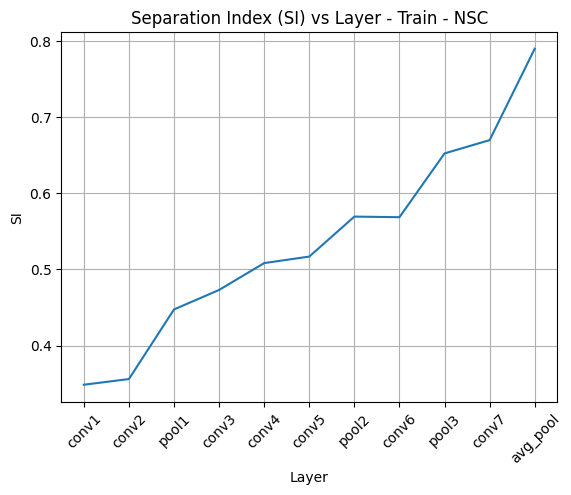

In [22]:
print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (CSI) vs Layer - Train - NSC')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## SI and CenterSI layer for Val Loader

In [8]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(val_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        # Flatten and concatenate the features for each layer
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    else:
        print(f"No features captured for layer {layer_name}")

# Concatenate the labels
labels = torch.cat(labels_list)

100%|██████████| 20/20 [00:00<00:00, 22.98it/s]


### Calc SI

In [9]:
si_layer_val = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=2000)
    si_layer_val.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 211.05it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4547.49it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4795.32it/s]

Data has been normalized



Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4946.11it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4385.82it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4612.50it/s]

Data has been normalized



Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5458.96it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4983.33it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5400.39it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4619.28it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4615.89it/s]


In [10]:
si_layer_val

[('conv1', 0.21079999208450317),
 ('conv2', 0.19759999215602875),
 ('pool1', 0.29019999504089355),
 ('conv3', 0.3343999981880188),
 ('conv4', 0.37379997968673706),
 ('conv5', 0.40959998965263367),
 ('pool2', 0.43779999017715454),
 ('conv6', 0.5263999700546265),
 ('pool3', 0.5101999640464783),
 ('conv7', 0.6137999892234802),
 ('avg_pool', 0.7407999634742737)]

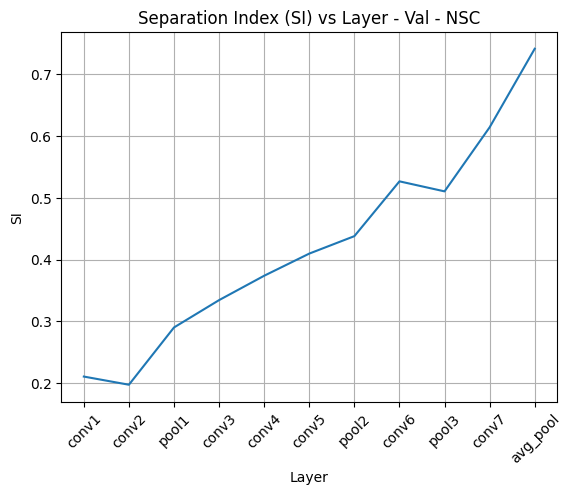

In [12]:
# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in si_layer_val], [si for _, si in si_layer_val])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (SI) vs Layer - Val - NSC')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### calc Center SI

In [13]:
csi_layer_val = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_val.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 415.17it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3043.76it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3040.09it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3190.39it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3277.65it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3349.19it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2966.97it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3135.54it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2997.36it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3249.72it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2029.83it/s]


[('conv1', 0.3617999851703644), ('conv2', 0.37139999866485596), ('pool1', 0.45739999413490295), ('conv3', 0.4860000014305115), ('conv4', 0.5216000080108643), ('conv5', 0.5263999700546265), ('pool2', 0.5766000151634216), ('conv6', 0.5627999901771545), ('pool3', 0.6583999991416931), ('conv7', 0.6681999564170837), ('avg_pool', 0.7913999557495117)]


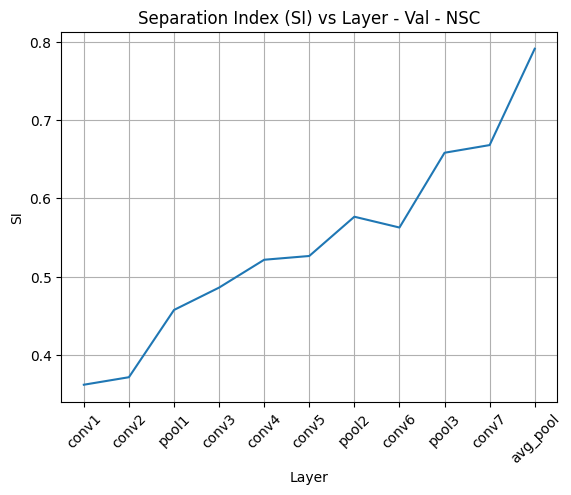

In [14]:
print(csi_layer_val)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_val], [si for _, si in csi_layer_val])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (CSI) vs Layer - Val - NSC')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## SI and CenterSI layer for Test Loader

In [9]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        # Flatten and concatenate the features for each layer
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    else:
        print(f"No features captured for layer {layer_name}")

# Concatenate the labels
labels = torch.cat(labels_list)

100%|██████████| 40/40 [00:01<00:00, 26.95it/s]


### Calc SI

In [10]:
si_layer_test = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=2000)
    si_layer_test.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 364.11it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7256.58it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7724.32it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6967.28it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7875.15it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7358.43it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7177.11it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7130.74it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7327.58it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7415.67it/s]

Data has been normalized



Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7761.48it/s]


In [11]:
si_layer_test

[('conv1', 0.22669999301433563),
 ('conv2', 0.21130000054836273),
 ('pool1', 0.30879998207092285),
 ('conv3', 0.36969998478889465),
 ('conv4', 0.42309999465942383),
 ('conv5', 0.4632999897003174),
 ('pool2', 0.4843999743461609),
 ('conv6', 0.5799999833106995),
 ('pool3', 0.5418999791145325),
 ('conv7', 0.6324999928474426),
 ('avg_pool', 0.6967999935150146)]

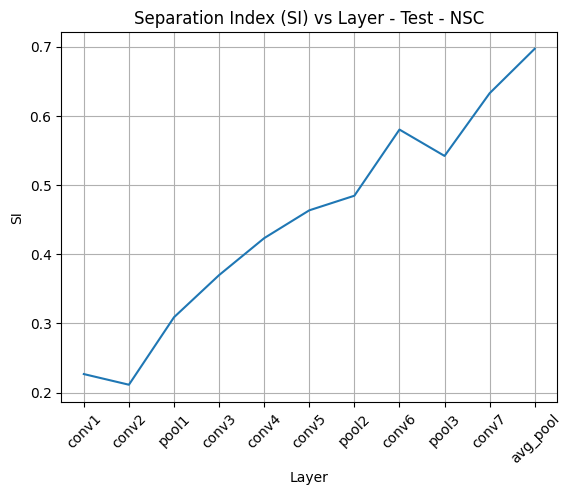

In [12]:
# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in si_layer_test], [si for _, si in si_layer_test])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (SI) vs Layer - Test - NSC')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Calc Center SI

In [13]:
csi_layer_test = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_test.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 856.23it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4336.54it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2981.03it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3293.78it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3313.04it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4492.61it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4030.66it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3301.04it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3979.42it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4107.23it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4047.77it/s]


[('conv1', 0.3544999957084656), ('conv2', 0.359499990940094), ('pool1', 0.4544999897480011), ('conv3', 0.47849997878074646), ('conv4', 0.5134999752044678), ('conv5', 0.5188999772071838), ('pool2', 0.5692999958992004), ('conv6', 0.5626999735832214), ('pool3', 0.6370999813079834), ('conv7', 0.651699960231781), ('avg_pool', 0.7382999658584595)]


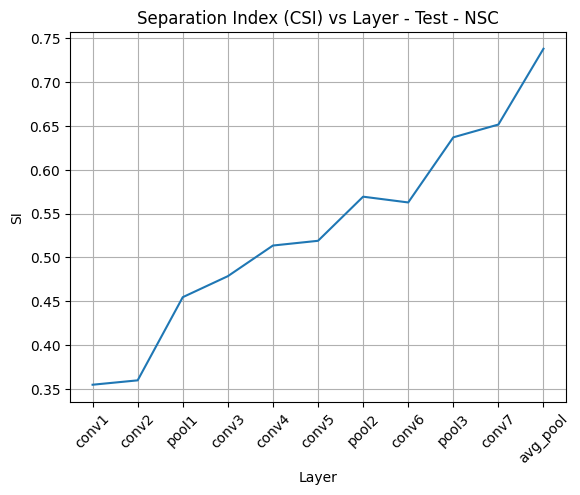

In [14]:
print(csi_layer_test)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_test], [si for _, si in csi_layer_test])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (CSI) vs Layer - Test - NSC')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()